# Benchmark



In [1]:
import numpy as np
import cvxpy as cp
from scipy.sparse import block_diag
import matplotlib.pyplot as plt

print(f'cvxpy version: {cp.__version__}')

cvxpy version: 1.3.0


In [2]:
E_dim = 70e3 # [Pa]
E = 70e3 / E_dim # [-] Young's modulus
nu = 0.3 # [-] Poisson's ratio 
sig0 = 250 / E_dim # [-] yield strength
Et = E/100. # [-] tangent modulus
H = E*Et/(E-Et) # [-] hardening modulus

l, m = lambda_, mu_ = E*nu/(1+nu)/(1-2*nu), E/2/(1+nu)   

# Elasticity stiffness matrix
C = np.array([[l+2*m, l, l, 0],
              [l, l+2*m, l, 0],
              [l, l, l+2*m, 0],
              [0, 0, 0, 2*m]])
S = np.linalg.inv(C)

def criterion(sig:cp.expressions.variable.Variable, p:cp.expressions.variable.Variable):
    """Creates a constraint for convex optimization problem in the form of von Mises criterion.
    
    Args:
        sig: A cvxpy variable of 4-dimensional Voigt vector of stresses
        p: A cvxpy variable of cumulated equivalent plastic strain
    
    Returns:    
        A list with a semi-definitive conic constraint in the form of von Mises yield criterion
    """
    N = p.size
    dev = np.array([[2/3., -1/3., -1/3., 0],
                    [-1/3., 2/3., -1/3., 0],
                    [-1/3., -1/3., 2/3., 0],
                    [0, 0, 0, 1.]])

    sig0_vec = np.repeat(sig0, N)
    s = dev @ sig

    return [np.sqrt(3/2)*cp.norm(s, axis=0) <= sig0_vec + p * H]

In [3]:
deps_npy = np.load('delta_epsilon.npy')
print(f'{deps_npy.shape} {deps_npy.size/4}')
N = patch_size = 500
deps_original = deps_npy[:4*N].reshape((N, 4))
deps_original.shape

(17736,) 4434.0


(500, 4)

In [4]:
particular_deps = np.array([ 7.24276667e-04, -3.41842340e-04,  0.00000000e+00, -2.65071262e-05])
deps_dummy = np.full((N,4), particular_deps)
deps_dummy.shape

(500, 4)

In [15]:
def run_test(conic_solver:str, deps_values:np.ndarray, verbose:bool = False):
    N = deps_values.shape[0]
    deps_original = deps_npy[:4*N].reshape((-1, N, 4)).squeeze()

    deps = cp.Parameter((4, N), name='deps')
    sig_old = cp.Parameter((4, N), name='sig_old')
    sig_elas = sig_old + C @ deps
    sig = cp.Variable((4, N), name='sig')
    p_old = cp.Parameter((N,), nonneg=True, name='p_old')
    p = cp.Variable((N,),nonneg=True, name='p')

    sig_old.value = np.zeros((4, N))
    deps.value = np.zeros((4, N))
    p_old.value = np.zeros((N,))
    print(deps.value.shape, deps_original.T.shape)
    deps.value = deps_original.T[:]

    delta_sig = sig - sig_elas
    D = H * np.eye(N)
    S_sparsed = block_diag([S for _ in range(N)])
    delta_sig_vector = cp.reshape(delta_sig, (N*4))

    elastic_energy = cp.quad_form(delta_sig_vector, S_sparsed, assume_PSD=True)
    target_expression = 0.5*elastic_energy + 0.5*cp.quad_form(p - p_old, D)
    constrains = criterion(sig, p) 

    opt_problem = cp.Problem(cp.Minimize(target_expression), constrains)

    conic_solver = 'SCS'
    tol_conic_solver = 1e-12
    conic_solver_params = {}

    if conic_solver == 'SCS':
        conic_solver_params = {
            'eps': tol_conic_solver,
            'eps_abs': tol_conic_solver, 
            'eps_rel': tol_conic_solver,
            'eps_infeas': tol_conic_solver,
        }
    elif conic_solver == 'ECOS':
        conic_solver_params = {'abstol': tol_conic_solver, 'reltol': tol_conic_solver}

    opt_problem.solve(solver=conic_solver, requires_grad=False, ignore_dpp=False, verbose=verbose, **conic_solver_params)

    return opt_problem

In [16]:
run_test('SCS', deps_dummy[:10], verbose=True)

(4, 10) (4, 10)
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 18 06:28:13 PM: Your problem has 50 variables, 1 constraints, and 90 parameters.
(CVXPY) May 18 06:28:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 18 06:28:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 18 06:28:13 PM: Compiling problem (target solver=SCS).
(CVXPY) May 18 06:28:13 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) May 18 06:28:13 PM: Applying reduction Dcp2Cone
(CVXPY) May 18 06:28:13 PM: Applying reduction CvxAttr2

Problem(Minimize(Expression(CONVEX, NONNEGATIVE, (1, 1))), [Inequality(Expression(CONVEX, NONNEGATIVE, (10,)))])

In [19]:
def run_benchmark():
    # N_list = np.array([1, 10, 100, 250])
    N_list = np.array([2, 10, 100, 250, 500, 1000])
    T_compil = {'SCS': [], 'ECOS': []}

    for solver in T_compil:
        print(f'Solver: {solver}')
        for N in N_list:
            solved_prob = run_test(solver, deps_dummy[:N])
            T_compil[solver].append(solved_prob._compilation_time)
            print(f'\tproblem dim: {N}\n\tsolution time: {solved_prob._solve_time}\n\tcompilation time: {solved_prob._compilation_time}\n')
    
    return N_list, T_compil

In [20]:
benchmark_results = run_benchmark()

Solver: SCS
(4, 2) (4, 2)
	problem dim: 2
	solution time: 0.0013895034790039062
	compilation time: 0.02916264533996582

(4, 10) (4, 10)
	problem dim: 10
	solution time: 0.002143383026123047
	compilation time: 0.03283834457397461

(4, 100) (4, 100)
	problem dim: 100
	solution time: 0.009993791580200195
	compilation time: 0.16749787330627441

(4, 250) (4, 250)
	problem dim: 250
	solution time: 0.022597312927246094
	compilation time: 0.8393590450286865

(4, 500) (4, 500)
	problem dim: 500
	solution time: 0.04857134819030762
	compilation time: 4.122195720672607

(4, 500) (4, 500)
	problem dim: 1000
	solution time: 0.040960073471069336
	compilation time: 2.8653903007507324

Solver: ECOS
(4, 2) (4, 2)
	problem dim: 2
	solution time: 0.0005655288696289062
	compilation time: 0.012406349182128906

(4, 10) (4, 10)
	problem dim: 10
	solution time: 0.0011005401611328125
	compilation time: 0.013216733932495117

(4, 100) (4, 100)
	problem dim: 100
	solution time: 0.008022069931030273
	compilation ti

In [ ]:
def show_results(N_list, T_comp):
    for solver in T_comp:
        plt.plot(5*N_list, T_comp[solver], "-o", label=solver)
    plt.xlabel("Dimension of vectorized conic problem")
    plt.ylabel("Compilation time")
    plt.legend()
    plt.show()

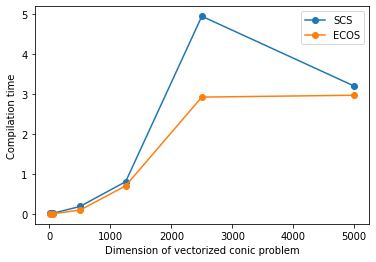

In [57]:
show_results(*benchmark_results)